# Exploratory Data Analysis

### Importing libraries

In [1]:
#data exploration&manipulation
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
import seaborn as sns

import datetime as dt
import os
import matplotlib.pyplot as plt

#ML Models search and optimisation
from pycaret.classification import * 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
#from sklearn.model_selection import GridSearchCV
#from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, confusion_matrix
import optuna
#from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

%matplotlib inline

### Reading the data set

In [2]:
   
# Import space_X_train.csv
import pandas as pd
space_X_train = pd.read_csv(r'C:\Users\march\000 Treball Ju`yter 000\Hackathons\Hackathon_Talent_Squad\initial_docs\space_X_train.csv')

In [3]:
space_X_train.head()


,Unnamed: 0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
0,0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


In [4]:
space_X_train.drop('Unnamed: 0',axis = 1 , inplace=True) #Drop unnecesary column

In [5]:
space_X_train.isnull().sum()

sensor_1    0
sensor_2    0
sensor_3    0
sensor_4    0
sensor_5    0
sensor_6    0
target      0
dtype: int64

In [7]:
space_X_train.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.204656,0.199249,-0.378140,-0.206425,-0.186419,-0.433229,1.980476
std,1.543613,1.614024,1.450548,1.442225,1.501573,1.188791,1.410537
min,-6.683655,-5.383371,-6.147055,-5.653594,-5.912521,-4.433189,0.000000
25%,-1.171340,-0.877386,-1.365990,-1.259403,-1.211685,-1.131944,1.000000
50%,-0.443868,0.320507,-0.439745,-0.176504,-0.195751,-0.406754,2.000000
75%,0.890023,1.321430,0.662898,0.866879,0.851843,0.348593,3.000000
max,4.565547,6.700133,4.157518,4.371912,5.068783,4.016324,4.000000


Values of sensors are very similar (range from -0.433 to 6.700). There is no null values to be cleaned.

In [8]:
y = space_X_train.target

Text(0, 0.5, '# of instances')

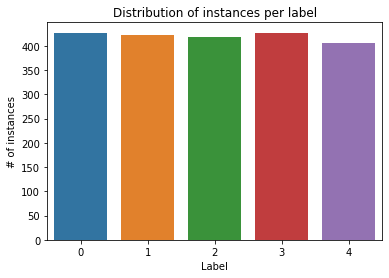

In [9]:
#Label distribution checking
counter = Counter(y)
dist_plot=sns.barplot(x=list(counter.keys()), y=list(counter.values()))
dist_plot.set_title('Distribution of instances per label')
dist_plot.set_xlabel('Label')
dist_plot.set_ylabel('# of instances')

In [10]:
ratio_labels= [x/len(y) for x in list(counter.values())]
ratio_labels

[0.19285714285714287,
 0.20333333333333334,
 0.20142857142857143,
 0.20285714285714285,
 0.19952380952380952]

Distribution of samples are very similiar each other, there is no minoritay/majotary class in the label column.

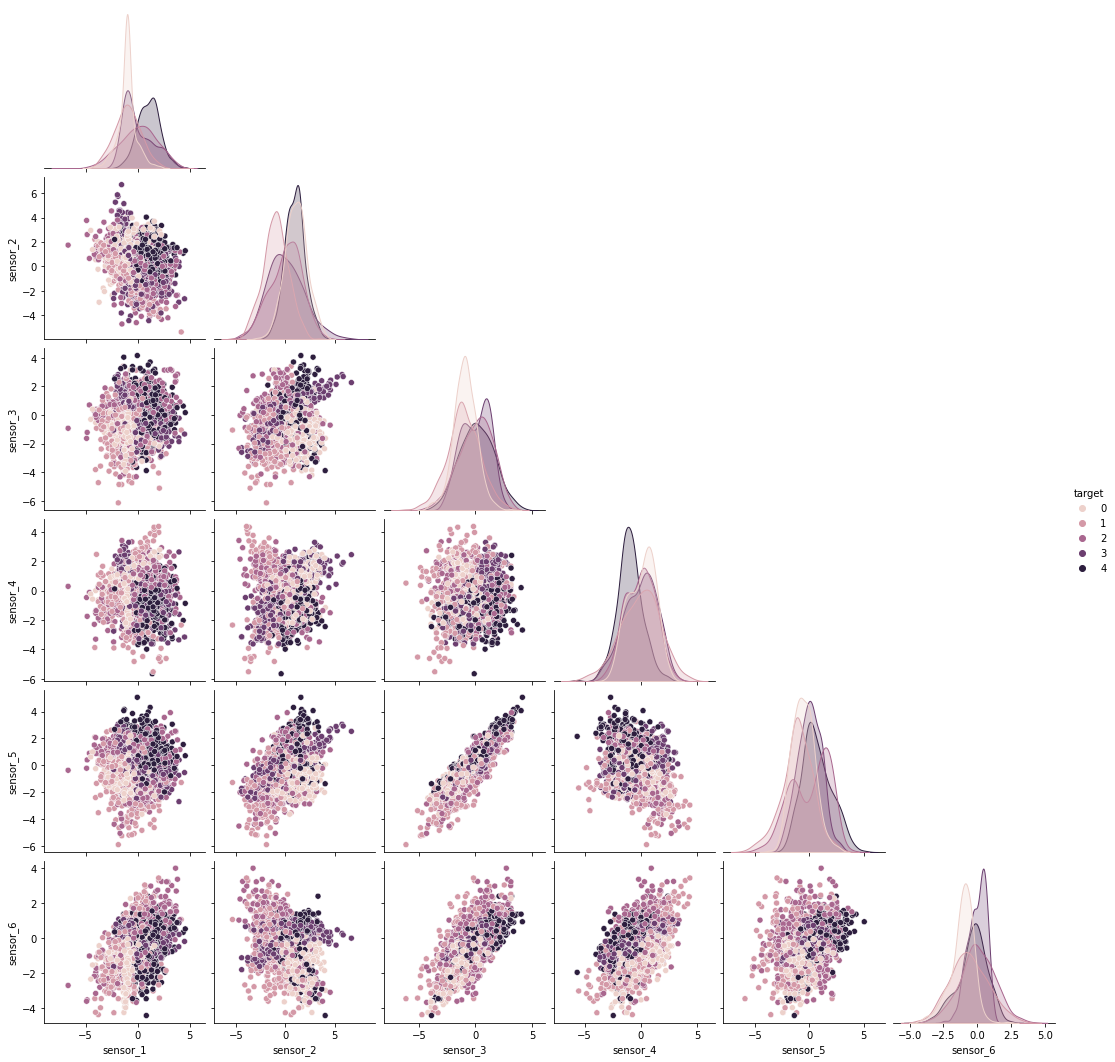

In [11]:
sns.pairplot(space_X_train, corner=True,hue='target')

In [ ]:
space_X_train_extra2= space_X_train.copy()
space_X_train_extra2['total_response']=space_X_train['sensor_1']+space_X_train['sensor_2']+space_X_train['sensor_3']+space_X_train['sensor_6']
sns.pairplot(space_X_train_extra2, corner=True, hue='target')

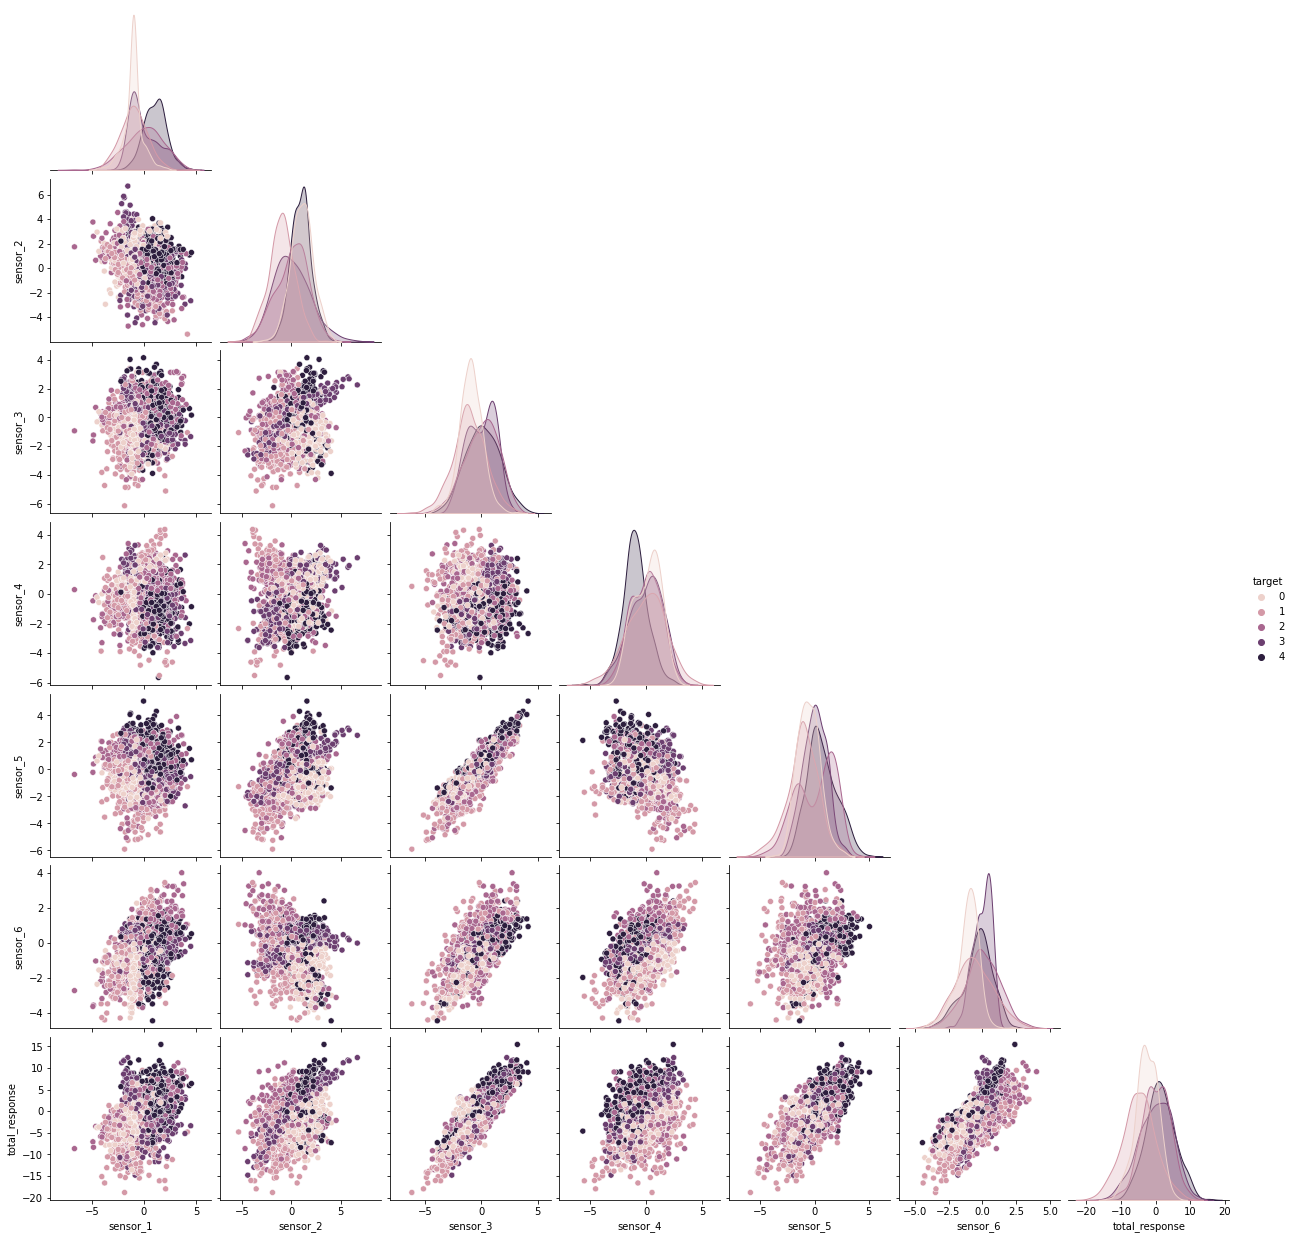

In [24]:
space_X_train_extra= space_X_train.copy()
space_X_train_extra['total_response']=space_X_train['sensor_1']+space_X_train['sensor_2']+space_X_train['sensor_3']+space_X_train['sensor_4']+space_X_train['sensor_5']+space_X_train['sensor_6']
sns.pairplot(space_X_train_extra, corner=True, hue='target')

<AxesSubplot:>

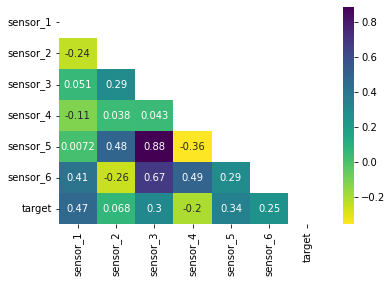

In [21]:
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(space_X_train.corr())

sns.heatmap(space_X_train.corr(), annot=True, cmap='viridis_r', mask=matrix)


In [8]:
import plotly.express as px

space_X_train_filtered = space_X_train

# Construct the graph and style it. 
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.box(space_X_train_filtered, x='target', y='Unnamed: 0', color='target')
fig.update_layout(
    title='target, Unnamed: 0 (first 1000 rows) box plot', 
    xaxis = dict(
        rangeslider = dict(
            visible=True, 
            thickness=0.05
        )
    ), 
    yaxis = dict(

    ), 
    barmode='stack', 
    paper_bgcolor='#FFFFFF', 
    showlegend=True
)
fig.show(renderer="iframe")

From the previous graph it can be concluded that:
* Each class has a gaussian type distribution.
* The different labels form clusters for certain sensors.

There is no need to clean or engineer the Data set.

In [24]:
space_X_train['Unnamed: 0']

0          0
1          1
2          2
3          3
4          4
        ... 
2095    2095
2096    2096
2097    2097
2098    2098
2099    2099
Name: Unnamed: 0, Length: 2100, dtype: int64

In [33]:
space_X_train.columns

Index(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'target'],
      dtype='object')

In [34]:
import pandas as pd
from sklearn import preprocessing

x = space_X_train.drop('target',axis=1).values #returns a numpy array
numerical_cols=['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6']

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
space_X_train_min_max_scaled = pd.DataFrame(x_scaled)

scaler = preprocessing.RobustScaler()
space_X_train_robust = scaler.fit_transform(x)
space_X_train_robust = pd.DataFrame(space_X_train_robust, columns =numerical_cols)

scaler = preprocessing.StandardScaler()
space_X_train_standard = scaler.fit_transform(x)
space_X_train_standard = pd.DataFrame(space_X_train_standard, columns =numerical_cols)


In [35]:
space_X_train_min_max_scaled ['target'] = space_X_train['target']
space_X_train_robust ['target'] = space_X_train['target']
space_X_train_standard ['target'] = space_X_train['target']


In [20]:
space_X_train_scaled['target'] = space_X_train['target']

## Model screening

With Pycaret we test the dataframe with several models to check its performance with :

In [39]:
setup(space_X_train,
          target='target'
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7624,0.9427,0.7629,0.7681,0.7621,0.7030,0.7045,0.5650
lightgbm,Light Gradient Boosting Machine,0.7583,0.9407,0.7593,0.7611,0.7567,0.6979,0.6993,0.7000
et,Extra Trees Classifier,0.7535,0.9432,0.7541,0.7584,0.7526,0.6919,0.6935,0.5420
knn,K Neighbors Classifier,0.7433,0.9220,0.7441,0.7462,0.7420,0.6792,0.6804,0.1460
gbc,Gradient Boosting Classifier,0.7297,0.9352,0.7308,0.7350,0.7279,0.6622,0.6642,1.3740
dt,Decision Tree Classifier,0.6637,0.7896,0.6641,0.6702,0.6622,0.5795,0.5815,0.0360
nb,Naive Bayes,0.5657,0.8371,0.5671,0.5661,0.5505,0.4572,0.4632,0.0320
ada,Ada Boost Classifier,0.5364,0.8043,0.5413,0.5273,0.5188,0.4212,0.4266,0.1740
lr,Logistic Regression,0.5275,0.7885,0.5324,0.5076,0.5010,0.4103,0.4168,0.0490
qda,Quadratic Discriminant Analysis,0.5221,0.8452,0.5185,0.5784,0.5120,0.4008,0.4148,0.0290


In [14]:
space_X_train_scaled['target'] = space_X_train['target']

Let's try with the data modified with scalers: MinMaxScaler, RobustScaler, 

In [36]:
setup(space_X_train_min_max_scaled,
          target='target'
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7481,0.9380,0.7488,0.7532,0.7442,0.6852,0.6879,0.4620
rf,Random Forest Classifier,0.7468,0.9423,0.7473,0.7538,0.7434,0.6835,0.6864,0.5650
gbc,Gradient Boosting Classifier,0.7386,0.9386,0.7391,0.7419,0.7350,0.6733,0.6756,1.3590
et,Extra Trees Classifier,0.7386,0.9433,0.7393,0.7431,0.7351,0.6733,0.6758,0.4550
knn,K Neighbors Classifier,0.7229,0.9217,0.7234,0.7271,0.7207,0.6537,0.6556,0.1080
qda,Quadratic Discriminant Analysis,0.6515,0.8984,0.6526,0.6688,0.6431,0.5646,0.5716,0.0410
dt,Decision Tree Classifier,0.6439,0.7775,0.6441,0.6514,0.6423,0.5549,0.5572,0.0280
nb,Naive Bayes,0.5664,0.8384,0.5669,0.5722,0.5512,0.4581,0.4639,0.0280
lda,Linear Discriminant Analysis,0.5582,0.7955,0.5594,0.5438,0.5351,0.4481,0.4547,0.0250
ada,Ada Boost Classifier,0.5555,0.8152,0.5561,0.5460,0.5363,0.4444,0.4505,0.1680


In [37]:
setup(space_X_train_standard,
          target='target'
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7611,0.9425,0.7608,0.7642,0.7592,0.7013,0.7028,0.4670
lightgbm,Light Gradient Boosting Machine,0.7488,0.9407,0.7485,0.7523,0.7477,0.6860,0.6872,0.4050
rf,Random Forest Classifier,0.7468,0.9421,0.7465,0.7500,0.7447,0.6834,0.6850,0.5270
gbc,Gradient Boosting Classifier,0.7338,0.9363,0.7334,0.7378,0.7322,0.6672,0.6688,1.2010
knn,K Neighbors Classifier,0.7222,0.9226,0.7220,0.7277,0.7206,0.6528,0.6547,0.1040
dt,Decision Tree Classifier,0.6739,0.7963,0.6735,0.6767,0.6732,0.5924,0.5933,0.0370
qda,Quadratic Discriminant Analysis,0.5582,0.8626,0.5585,0.6060,0.5523,0.4479,0.4604,0.0360
nb,Naive Bayes,0.5555,0.8377,0.5541,0.5507,0.5386,0.4441,0.4496,0.0330
ada,Ada Boost Classifier,0.5534,0.8093,0.5520,0.5449,0.5412,0.4415,0.4447,0.1930
lr,Logistic Regression,0.5262,0.7925,0.5249,0.4987,0.4996,0.4075,0.4133,0.0540


In [38]:
setup(space_X_train_robust,
          target='target'
    )
best_model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7577,0.9422,0.7584,0.7628,0.7576,0.6970,0.6982,0.4650
rf,Random Forest Classifier,0.7563,0.9432,0.7572,0.7624,0.7561,0.6953,0.6968,0.6180
lightgbm,Light Gradient Boosting Machine,0.7427,0.9438,0.7435,0.7475,0.7423,0.6783,0.6796,0.4980
gbc,Gradient Boosting Classifier,0.7359,0.9367,0.7369,0.7390,0.7346,0.6698,0.6711,1.2910
knn,K Neighbors Classifier,0.7331,0.9233,0.7339,0.7394,0.7321,0.6663,0.6682,0.1300
dt,Decision Tree Classifier,0.6740,0.7960,0.6750,0.6772,0.6726,0.5924,0.5937,0.0380
qda,Quadratic Discriminant Analysis,0.5630,0.8507,0.5622,0.5819,0.5574,0.4533,0.4590,0.0270
nb,Naive Bayes,0.5582,0.8320,0.5603,0.5589,0.5445,0.4480,0.4532,0.0290
ada,Ada Boost Classifier,0.5446,0.7946,0.5479,0.5437,0.5302,0.4313,0.4368,0.1750
lr,Logistic Regression,0.5343,0.7932,0.5369,0.5118,0.5122,0.4182,0.4230,0.0560


## Random Forest Hyperparameters tunning with Optuna

In [11]:
def scoring_f1(y_test,X_test,method): #generation of f1 macro
    f1score=f1_score(y_test,
                     method.predict(X_test),
                     average= 'macro'
)        
    return f1score  

In [12]:
import optuna

In [13]:
X=space_X_train.copy()
y=X.target
X.drop('target',axis=1, inplace=True)

In [14]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    max_depth = trial.suggest_int('max_depth', 1, 10000)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 20)
    
    rf_cl = RandomForestClassifier(bootstrap = bootstrap, 
                                   max_depth = max_depth, 
                                   max_features = max_features,
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


In [15]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2022-06-14 19:08:36,933] A new study created in memory with name: no-name-98b8ddea-1240-46c0-96df-138d4fd2356e
[I 2022-06-14 19:09:10,048] Trial 0 finished with value: 0.7199957808974002 and parameters: {'bootstrap': 'True', 'max_depth': 163, 'max_features': 'sqrt', 'max_leaf_nodes': 1773, 'n_estimators': 288, 'n_jobs': 15}. Best is trial 0 with value: 0.7199957808974002.
[I 2022-06-14 19:09:27,798] Trial 1 finished with value: 0.7169085773663529 and parameters: {'bootstrap': 'False', 'max_depth': 9579, 'max_features': 'log2', 'max_leaf_nodes': 7828, 'n_estimators': 611, 'n_jobs': 13}. Best is trial 0 with value: 0.7199957808974002.
[I 2022-06-14 19:09:46,584] Trial 2 finished with value: 0.7194050923748266 and parameters: {'bootstrap': 'True', 'max_depth': 3402, 'max_features': 'sqrt', 'max_leaf_nodes': 4552, 'n_estimators': 797, 'n_jobs': 5}. Best is trial 0 with value: 0.7199957808974002.
[I 2022-06-14 19:10:12,436] Trial 3 finished with value: 0.7180946468265417 and parameters: 

In [17]:
import plotly.io as pio #To fix an issue with the renderer of graphs in VSC
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [18]:
pio.renderers.default = "notebook_connected"

In [20]:
optuna.visualization.plot_param_importances(study).show()

In [22]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [21]:
study.best_params

{'bootstrap': 'False',
 'max_depth': 8144,
 'max_features': 'auto',
 'max_leaf_nodes': 4511,
 'n_estimators': 452,
 'n_jobs': 20}

In [26]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1, 10000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 2, 20)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-14 19:41:38,697] Trial 20 finished with value: 0.7069452278895854 and parameters: {'max_depth': 3845, 'max_leaf_nodes': 6557, 'n_estimators': 170, 'n_jobs': 12}. Best is trial 10 with value: 0.7210648135957081.
[I 2022-06-14 19:41:52,170] Trial 21 finished with value: 0.7131391841978006 and parameters: {'max_depth': 747, 'max_leaf_nodes': 1976, 'n_estimators': 352, 'n_jobs': 15}. Best is trial 10 with value: 0.7210648135957081.
[I 2022-06-14 19:42:07,232] Trial 22 finished with value: 0.705256637995048 and parameters: {'max_depth': 553, 'max_leaf_nodes': 1604, 'n_estimators': 519, 'n_jobs': 16}. Best is trial 10 with value: 0.7210648135957081.
[I 2022-06-14 19:42:17,754] Trial 23 finished with value: 0.7228609674098099 and parameters: {'max_depth': 2363, 'max_leaf_nodes': 3708, 'n_estimators': 251, 'n_jobs': 18}. Best is trial 23 with value: 0.7228609674098099.
[I 2022-06-14 19:42:26,376] Trial 24 finished with value: 0.7229900444069913 and parameters: {'max_depth': 2516, 'm

In [27]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [28]:
optuna.visualization.plot_param_importances(study).show()

In [29]:
study.best_params

{'max_depth': 55, 'max_leaf_nodes': 6969, 'n_estimators': 109, 'n_jobs': 18}

In [30]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1, 10000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4000, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 100, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 18, 25)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-14 19:51:04,986] Trial 40 finished with value: 0.7133750944305781 and parameters: {'max_depth': 2852, 'max_leaf_nodes': 4088, 'n_estimators': 309, 'n_jobs': 19}. Best is trial 30 with value: 0.7245342823520504.
[I 2022-06-14 19:51:11,575] Trial 41 finished with value: 0.7269133011802549 and parameters: {'max_depth': 4200, 'max_leaf_nodes': 4161, 'n_estimators': 213, 'n_jobs': 19}. Best is trial 41 with value: 0.7269133011802549.
[I 2022-06-14 19:51:19,055] Trial 42 finished with value: 0.715186472358449 and parameters: {'max_depth': 4291, 'max_leaf_nodes': 4044, 'n_estimators': 240, 'n_jobs': 19}. Best is trial 41 with value: 0.7269133011802549.
[I 2022-06-14 19:51:27,803] Trial 43 finished with value: 0.7093909976228052 and parameters: {'max_depth': 2092, 'max_leaf_nodes': 4226, 'n_estimators': 287, 'n_jobs': 19}. Best is trial 41 with value: 0.7269133011802549.
[I 2022-06-14 19:51:34,419] Trial 44 finished with value: 0.7000309887842627 and parameters: {'max_depth': 3270, 

In [31]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [32]:
optuna.visualization.plot_param_importances(study).show()

In [33]:
study.best_params

{'max_depth': 4973, 'max_leaf_nodes': 4197, 'n_estimators': 439, 'n_jobs': 20}

In [34]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 4000, 8000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4000, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 100, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 20, 25)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'auto',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-14 20:00:46,692] Trial 60 finished with value: 0.7192603023204411 and parameters: {'max_depth': 4042, 'max_leaf_nodes': 4306, 'n_estimators': 554, 'n_jobs': 21}. Best is trial 56 with value: 0.7288800801592215.
[I 2022-06-14 20:01:10,151] Trial 61 finished with value: 0.714372272082161 and parameters: {'max_depth': 4049, 'max_leaf_nodes': 4116, 'n_estimators': 638, 'n_jobs': 20}. Best is trial 56 with value: 0.7288800801592215.
[I 2022-06-14 20:01:20,207] Trial 62 finished with value: 0.7123484136383469 and parameters: {'max_depth': 4046, 'max_leaf_nodes': 4091, 'n_estimators': 363, 'n_jobs': 20}. Best is trial 56 with value: 0.7288800801592215.
[I 2022-06-14 20:01:30,222] Trial 63 finished with value: 0.7217815674854979 and parameters: {'max_depth': 4013, 'max_leaf_nodes': 4182, 'n_estimators': 305, 'n_jobs': 20}. Best is trial 56 with value: 0.7288800801592215.
[I 2022-06-14 20:01:43,698] Trial 64 finished with value: 0.7151008827425824 and parameters: {'max_depth': 4011, 

In [35]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [36]:
optuna.visualization.plot_param_importances(study).show()

In [37]:
study.best_params

{'max_depth': 4973, 'max_leaf_nodes': 4197, 'n_estimators': 439, 'n_jobs': 20}

In [38]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
  
    n_jobs =  trial.suggest_int('n_jobs', 18, 25)
    bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
        
    rf_cl = RandomForestClassifier(bootstrap = bootstrap, 
                                   max_depth = 4973, 
                                   max_features =  max_features,
                                   max_leaf_nodes = 4197,
                                   n_estimators = 439,
                                   n_jobs = n_jobs
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-14 20:13:07,092] Trial 80 finished with value: 0.711259296966602 and parameters: {'n_jobs': 19, 'bootstrap': 'False', 'max_features': 'log2'}. Best is trial 56 with value: 0.7288800801592215.
[I 2022-06-14 20:13:25,395] Trial 81 finished with value: 0.7267282760047161 and parameters: {'n_jobs': 21, 'bootstrap': 'True', 'max_features': 'log2'}. Best is trial 56 with value: 0.7288800801592215.
[I 2022-06-14 20:13:38,218] Trial 82 finished with value: 0.7034631907019102 and parameters: {'n_jobs': 21, 'bootstrap': 'True', 'max_features': 'log2'}. Best is trial 56 with value: 0.7288800801592215.
[I 2022-06-14 20:13:53,301] Trial 83 finished with value: 0.7120005286547302 and parameters: {'n_jobs': 22, 'bootstrap': 'True', 'max_features': 'log2'}. Best is trial 56 with value: 0.7288800801592215.
[I 2022-06-14 20:14:06,718] Trial 84 finished with value: 0.7123344693197934 and parameters: {'n_jobs': 22, 'bootstrap': 'True', 'max_features': 'log2'}. Best is trial 56 with value: 0.728

In [46]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [47]:
# fix the less relevant parameter to continue the optimization
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    max_depth = trial.suggest_int('max_depth', 1, 10000)   
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 4000, 10000)
    n_estimators =  trial.suggest_int('n_estimators', 100, 1000)
    n_jobs =  trial.suggest_int('n_jobs', 18, 25)
    
    rf_cl = RandomForestClassifier(bootstrap = 'False', 
                                   max_depth = max_depth, 
                                   max_features = 'log2',
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs = n_jobs
                                  )
    
    rf_cl.fit(X_train, y_train)
    y_pred = rf_cl.predict(X_test)
    
    score = cross_val_score(rf_cl, X_test, y_test, cv=5, scoring="f1_macro")
    f1_mean = score.mean()

    return f1_mean


study.optimize(objective, n_trials=20)

[I 2022-06-14 20:31:22,742] Trial 106 finished with value: 0.7024100929597044 and parameters: {'max_depth': 3612, 'max_leaf_nodes': 4418, 'n_estimators': 584, 'n_jobs': 20}. Best is trial 56 with value: 0.7288800801592215.
[I 2022-06-14 20:31:42,502] Trial 107 finished with value: 0.7168147092204153 and parameters: {'max_depth': 4576, 'max_leaf_nodes': 4215, 'n_estimators': 684, 'n_jobs': 21}. Best is trial 56 with value: 0.7288800801592215.
[I 2022-06-14 20:31:56,608] Trial 108 finished with value: 0.7138924465659697 and parameters: {'max_depth': 4663, 'max_leaf_nodes': 4200, 'n_estimators': 463, 'n_jobs': 21}. Best is trial 56 with value: 0.7288800801592215.
[I 2022-06-14 20:32:13,907] Trial 109 finished with value: 0.7144179752512917 and parameters: {'max_depth': 4905, 'max_leaf_nodes': 4184, 'n_estimators': 613, 'n_jobs': 21}. Best is trial 56 with value: 0.7288800801592215.
[I 2022-06-14 20:32:30,373] Trial 110 finished with value: 0.7090607641727755 and parameters: {'max_depth': 

In [49]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:

sampler = optuna.samplers.RandomSampler(seed=10)
study = optuna.create_study(sampler=sampler)
study.optimize(objective, n_trials=100)

fig = optuna.visualization.plot_param_importances(study)
fig.show()

## Neuronal Network Hyperparameters tunning with Optuna

In [56]:
import torch

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels=list(df.target)
        self.features = df.drop(columns=['target'], axis=1).values.tolist()

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_features(self, idx):
        return np.array(self.features[idx])

    def __getitem__(self, idx):
        batch_features = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_features, batch_y

In [55]:
def build_model(params):
    
    in_features = 6 #number of features, it can be changed if new columns added
    
    return nn.Sequential(
    
        nn.Linear(in_features, params['n_unit']),
        nn.LeakyReLU(),
        nn.Linear(params['n_unit'], 2),
        nn.LeakyReLU()
        
    )
 


In [59]:
 
# Train and evaluate the accuarcy of neural network model
def train_and_evaluate(df, param, model):
        
    train_data, val_data = train_test_split(df, test_size = 0.2, random_state = 42)
    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in train_dataloader:

                train_label = train_label.to(device)
                train_input = train_input.to(device)

                output = model(train_input.float())
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input.float())

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            #accuracy = total_acc_val/len(val_data)
            f1macro= f1_score(val_label, 
                            output.argmax(dim=1), 
                            average = 'macro'
                            )
            

    return f1macro
  

In [60]:
 # Define a set of hyperparameter values, build the model, train the model, and evaluate the f1 screo 
def objective(trial):

     params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'n_unit': trial.suggest_int("n_unit", 4, 18)
              }
    
     model = build_model(params)
    
     f1macro = train_and_evaluate(params, model)

     return f1macro

In [61]:

EPOCHS = 30
    
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2022-06-14 21:25:17,591] A new study created in memory with name: no-name-85f95a65-5bab-429a-9656-e1f00a43eae9
[W 2022-06-14 21:25:17,600] Trial 0 failed because of the following error: NameError("name 'nn' is not defined")
Traceback (most recent call last):
  File "c:\Users\march\anaconda3\envs\EDA_i_ML_37\lib\site-packages\optuna\study\_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\march\AppData\Local\Temp\ipykernel_2288\2736809180.py", line 10, in objective
    model = build_model(params)
  File "C:\Users\march\AppData\Local\Temp\ipykernel_2288\2728040426.py", line 5, in build_model
    return nn.Sequential(
NameError: name 'nn' is not defined


NameError: name 'nn' is not defined

In [28]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X, y = make_classification(n_features=10, random_state=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    C = trial.suggest_loguniform("C", 1e-7, 10.0)
    clf = LogisticRegression(C=C)
    clf.fit(X_train, y_train)
    # calculate more evaluation metrics
    pred = clf.predict(X_test)
    acc = metrics.accuracy_score(pred, y_test)
    recall = metrics.recall_score(pred, y_test)
    precision = metrics.precision_score(pred, y_test)
    f1 = metrics.f1_score(pred, y_test)
    return acc, f1, recall, precision


In [342]:
param_test1 = {'n_estimators':range(20,300,10)}
gsearch1 = GridSearchCV(estimator = ExtraTreesClassifier(),
                        param_grid = param_test1, 
                        n_jobs = 4, 
                        cv = 5,
                        verbose = 4,
)

gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    9.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   45.5s
[Parallel(n_jobs=4)]: Done 140 out of 140 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid='deprecate

In [343]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 240}, 0.689068136145903)

In [351]:
scoring_f1(y_test,X_test,gsearch1)

0.7137069661061817

In [345]:
param_test2 = {'n_estimators':[240], 'criterion': ['gini', 'entropy', 'log_loss']}
gsearch2 = GridSearchCV(estimator = ExtraTreesClassifier(),
                        param_grid = param_test2, 
                        n_jobs = 4, 
                        cv = 5,
                        verbose = 4,
)

gsearch2.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:   16.7s remaining:    4.1s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   18.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid='deprecate

In [346]:
gsearch2.best_params_, gsearch2.best_score_

({'criterion': 'entropy', 'n_estimators': 240}, 0.6879447934176766)

In [350]:
scoring_f1(y_test,X_test,gsearch2)

0.7126813595129133

In [352]:
param_test3 = {'n_estimators':[240], 'criterion': ['entropy']}
gsearch3 = GridSearchCV(estimator = ExtraTreesClassifier(),
                        param_grid = param_test3, 
                        n_jobs = 4, 
                        cv = 5,
                        verbose = 4,
)

gsearch3.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   10.7s remaining:   16.1s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   13.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid='deprecate

## test_X prediction

To take advantage of all the dataset, the model with the best hyperparameters is fitted with the whole train data:

In [362]:
best_final_model = ExtraTreesClassifier(class_weight=None, 
                                  criterion='entropy',
                                max_depth=None, 
                                max_features='auto',
                                max_leaf_nodes=None,
                                max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0,
                                n_estimators=240, 
                                n_jobs=5,
                                random_state=None,
                                )

In [369]:
X.drop('index', axis=1,inplace=True)

In [370]:
best_final_model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=240, n_jobs=5,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

Charge test_X dataset to be predicted. First of all, additional columns have to be generated as the most useful dataframe (ibex_df4):

In [371]:
test_x=pd.read_csv('C:/Users/march/000 Treball Ju`yter 000/Hackathons/Tech_laCaixa2022/test_x.csv',index_col=None)

test_x.isnull().sum()

test_index    0
Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
dtype: int64

In [372]:
test_x.shape

(726, 8)

In [373]:

test_x

,test_index,Date,Open,High,Low,Close,Adj Close,Volume
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0
...,...,...,...,...,...,...,...,...
721,7278,2022-03-25,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0
722,7279,2022-03-28,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0
723,7280,2022-03-29,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0
724,7281,2022-03-30,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0


In [374]:
test_x. rename(columns = {'test_index':'day'}, inplace = True)
test_x.drop('Date',axis=1,inplace=True)

test_x

,day,Open,High,Low,Close,Adj Close,Volume
0,6557,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
1,6558,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
2,6559,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
3,6560,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
4,6561,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0
...,...,...,...,...,...,...,...
721,7278,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0
722,7279,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0
723,7280,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0
724,7281,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0


In [375]:
test_x['Oscillation']   = test_x['High']- test_x['Low']
test_x['daily_variation']= test_x['Close']- test_x['Open']

test_x['MA_200_dias'] = test_x['Close'].rolling(200).mean()
test_x['MA_20_dias'] = test_x['Close'].rolling(20).mean()
test_x['MA_5_dias'] = test_x['Close'].rolling(5).mean()
test_x['MA_3_dias'] = test_x['Close'].rolling(3).mean()

test_x['dist_Max_200_d'] = test_x['Close']-test_x['Close'].rolling(200).max()
test_x['dist_Max_50_d'] = test_x['Close']-test_x['Close'].rolling(50).max()
test_x['dist_Max_20_d'] = test_x['Close']-test_x['Close'].rolling(20).max()

test_x['dist_Min_200_d'] = test_x['Close']-test_x['Close'].rolling(200).min()
test_x['dist_Min_50_d'] = test_x['Close']-test_x['Close'].rolling(50).min()
test_x['dist_Min_20_d'] = test_x['Close']-test_x['Close'].rolling(20).min()


In [376]:
index_new=list(test_x.day)

In [377]:
test_x.index=index_new
test_x

,day,Open,High,Low,Close,Adj Close,Volume,Oscillation,daily_variation,MA_200_dias,MA_20_dias,MA_5_dias,MA_3_dias,dist_Max_200_d,dist_Max_50_d,dist_Max_20_d,dist_Min_200_d,dist_Min_50_d,dist_Min_20_d
6557,6557,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0,78.400391,13.700195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6558,6558,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0,109.500000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6559,6559,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0,75.700196,49.399414,NaN,NaN,NaN,9185.266601,NaN,NaN,NaN,NaN,NaN,NaN
6560,6560,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0,54.100586,9.899414,NaN,NaN,NaN,9233.133138,NaN,NaN,NaN,NaN,NaN,NaN
6561,6561,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0,59.099609,-6.500000,NaN,NaN,9226.399804,9270.766276,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7278,7278,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0,76.700195,16.500000,8716.979521,8202.210010,8368.100000,8321.366536,-865.300782,-555.600586,-156.600586,685.999511,685.999511,685.999511
7279,7279,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0,131.299804,11.199218,8712.828018,8196.529980,8363.379883,8333.766276,-817.000000,-520.600586,-121.600586,720.999511,720.999511,720.999511
7280,7280,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0,201.299805,163.599609,8710.748018,8217.849951,8388.859765,8436.932942,-568.000000,-271.600586,0.000000,969.999511,969.999511,969.999511
7281,7281,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0,88.500000,-32.700196,8708.242515,8229.329932,8433.299609,8510.266276,-632.000000,-335.600586,-64.000000,905.999511,905.999511,905.999511


To fill the nan values in the test_x, it can be concatenated to initial dataframe to calculate moving averages, distances to maximums an minimums:

In [378]:
ibex_df4_NoTarget=ibex_df4.copy()
ibex_df4_NoTarget.drop('Target', axis=1,inplace=True)
ibex_df4_NoTarget

,day,Open,High,Low,Close,Adj Close,Volume,Oscillation,daily_variation,MA_200_dias,MA_20_dias,MA_5_dias,MA_3_dias,dist_Max_200_d,dist_Max_50_d,dist_Max_20_d,dist_Min_200_d,dist_Min_50_d,dist_Min_20_d
0,0,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,73.699951,39.300049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,50.399902,-24.199951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,41.800049,-4.000000,NaN,NaN,NaN,3635.333333,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,41.800049,-4.000000,NaN,NaN,NaN,3624.233317,NaN,NaN,NaN,NaN,NaN,NaN
4,4,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,45.699951,15.199951,NaN,NaN,3632.719971,3626.266601,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6549,6549,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,69.699218,24.299804,9157.978975,9266.144873,9191.919922,9173.599935,-485.200196,-407.300782,-396.000000,810.699218,127.799804,127.799804
6550,6550,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,89.899414,-9.500000,9156.050478,9251.664892,9195.259961,9168.333333,-443.399414,-365.500000,-354.199218,852.500000,169.600586,169.600586
6551,6551,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,92.000000,-28.600586,9154.357476,9235.394873,9185.800000,9194.266602,-468.000000,-390.100586,-378.799804,827.899414,145.000000,145.000000
6552,6552,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,81.600586,-32.700195,9152.224976,9210.889892,9155.459961,9162.900065,-579.299805,-501.400391,-337.700195,716.599609,33.700195,33.700195


In [379]:
total_ibex_df.iloc[6554:6753] #raws of the test_x with nan:

,day,Open,High,Low,Close,Adj Close,Volume,Oscillation,daily_variation,MA_200_dias,MA_20_dias,MA_5_dias,MA_3_dias,dist_Max_200_d,dist_Max_50_d,dist_Max_20_d,dist_Min_200_d,dist_Min_50_d,dist_Min_20_d
6557,6557,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0,78.400391,13.700195,9149.695474,9184.914893,9159.400000,9129.599935,-509.299805,-431.400391,-180.500000,786.599609,103.700195,103.700195
6558,6558,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0,109.500000,0.000000,9148.454976,9176.824902,9149.959961,9159.166667,-490.599610,-412.700196,-135.099610,805.299804,122.400390,122.400390
6559,6559,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0,75.700196,49.399414,9147.292476,9176.874902,9158.819922,9185.266601,-423.700196,-345.800782,-68.200196,872.199218,189.299804,189.299804
6560,6560,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0,54.100586,9.899414,9146.017974,9180.229883,9201.539844,9233.133138,-365.700196,-287.800782,-10.200196,930.199218,247.299804,247.299804
6561,6561,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0,59.099609,-6.500000,9144.527471,9189.574853,9226.399804,9270.766276,-377.700196,-299.800782,-22.200196,918.199218,235.299804,235.299804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6751,6751,8960.799805,8962.500000,8639.900391,8683.000000,8683.000000,342803500.0,322.599609,-277.799805,9264.126755,9507.584961,8773.859961,8801.533203,-1400.599609,-1400.599609,-1400.599609,164.000000,0.000000,0.000000
6752,6752,8532.599609,8542.000000,8310.400391,8375.599609,8375.599609,345901100.0,231.599609,-157.000000,9260.131755,9435.814941,8704.339844,8656.199870,-1708.000000,-1708.000000,-1708.000000,0.000000,0.000000,0.000000
6753,6753,7884.000000,8022.899902,7621.399902,7708.700195,7708.700195,598769200.0,401.500000,-175.299805,9252.593254,9330.449951,8497.779883,8255.766601,-2374.899414,-2374.899414,-2374.899414,0.000000,0.000000,0.000000
6754,6754,7815.600098,8007.700195,7440.600098,7461.500000,7461.500000,506034000.0,567.100097,-354.100098,9243.941755,9209.394971,8227.759961,7848.599935,-2622.099609,-2622.099609,-2622.099609,0.000000,0.000000,0.000000


In [380]:
total_ibex_df  = pd.concat([ibex_df4_NoTarget,test_x])
total_ibex_df.shape

(7280, 19)

In [381]:
total_ibex_df['Oscillation']   = total_ibex_df['High']- total_ibex_df['Low']
total_ibex_df['daily_variation']= total_ibex_df['Close']- total_ibex_df['Open']

total_ibex_df['MA_200_dias'] = total_ibex_df['Close'].rolling(200).mean()
total_ibex_df['MA_20_dias'] = total_ibex_df['Close'].rolling(20).mean()
total_ibex_df['MA_5_dias'] = total_ibex_df['Close'].rolling(5).mean()
total_ibex_df['MA_3_dias'] = total_ibex_df['Close'].rolling(3).mean()

total_ibex_df['dist_Max_200_d'] = total_ibex_df['Close']-total_ibex_df['Close'].rolling(200).max()
total_ibex_df['dist_Max_50_d'] = total_ibex_df['Close']-total_ibex_df['Close'].rolling(50).max()
total_ibex_df['dist_Max_20_d'] = total_ibex_df['Close']-total_ibex_df['Close'].rolling(20).max()

total_ibex_df['dist_Min_200_d'] = total_ibex_df['Close']-total_ibex_df['Close'].rolling(200).min()
total_ibex_df['dist_Min_50_d'] = total_ibex_df['Close']-total_ibex_df['Close'].rolling(50).min()
total_ibex_df['dist_Min_20_d'] = total_ibex_df['Close']-total_ibex_df['Close'].rolling(20).min()


In [382]:
test_x_modified= total_ibex_df.iloc[6554:].copy()
test_x_modified.shape

(726, 19)

In [385]:
x_test_pred=best_final_model.predict(test_x_modified)
x_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [397]:
predictions_df=pd.DataFrame({'Predictions': list(x_test_pred)} )

In [401]:
predictions_df['test_index']=index_new
predictions_df.index= predictions_df['test_index']
predictions_df.drop('test_index',axis=1,inplace=True)
predictions_df

,Predictions
test_index,
6557,0
6558,0
6559,0
6560,0
6561,0
...,...
7278,1
7279,1
7280,1


In [402]:
predictions_df.to_csv('C:/Users/march/000 Treball Ju`yter 000/Hackathons/Tech_laCaixa2022/predictions.csv')

In [403]:
predictions_df.to_json('C:/Users/march/000 Treball Ju`yter 000/Hackathons/Tech_laCaixa2022/predictions.json')

In [438]:
import pysentimiento

In [425]:
tweet_df=pd.read_csv('C:/Users/march/000 Treball Ju`yter 000/Hackathons/Tech_laCaixa2022/tweets_from2015_#Ibex35.csv')

In [431]:
tweet_df

,tweetDate,handle,text,año
0,Sat Apr 09 14:47:45 +0000 2022,abelac62,He hecho el repaso de todos los componentes de...,object
1,Thu Apr 07 19:14:36 +0000 2022,LluisPerarnau,Els projectes que han presentat les empreses d...,object
2,Mon Apr 04 16:48:45 +0000 2022,Pegaso121080,"Por si no lo has visto, o no lo encuentras en ...",object
3,Tue Apr 05 07:23:16 +0000 2022,zonavalue,📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 ...,object
4,Thu Mar 31 16:07:43 +0000 2022,EPeconomia,"El #Ibex35 retrocede un 0,4% en marzo y un 3,0...",object
...,...,...,...,...
9796,Thu Jan 08 16:41:36 +0000 2015,elEconomistaes,"#Cierre | El #Ibex35 sube un 2,26% hasta los 1...",object
9797,Sat Jan 03 17:20:30 +0000 2015,Roger_bolsa,Un vistazo a los #Bluechips del #Ibex #Ibex35....,object
9798,Sat Jan 10 19:42:45 +0000 2015,Secretosdebolsa,Así comienza la #Bolsa en #2015 Ojo a los sopo...,object
9799,Sat Jan 10 21:47:17 +0000 2015,Roger_bolsa,Análisis del #BancoSantander #Santander #SAN t...,object
